# 텍스트 순차열 데이터 예측 Template

# 데이터 준비

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


## 기반 문자열 생성

In [ ]:
BASE_STRING = "0123456789"
CATEGORY_NUM = len(BASE_STRING)

In [ ]:
SEQUENCE_LENGTH = 5
OFFSET = 1

## 입출력 데이터 생성

'abcde12345abcde'의 문자열로 다음의 입출력 데이터를 생성한다.
```
'abcde' -> '1'
'bcde1' -> '2'
'cde12' -> '3'
'de123' -> '4'
...
'5abcd' -> 'e'
```

In [ ]:
raw_x = []
raw_y = []

for i in range(100,1000):
    for j in range(100,1000):
        raw_x.append(str(i)+str(j))
        raw_y.append(str(i+j)[-1:])


In [ ]:
print(len(raw_x))
# len(raw_x) = 94 = len(text_data) - SEQUENCE_LENGTH - OFFSET = 100 - 5 - 1

810000


In [ ]:
print(raw_x[:5])
print(raw_y[:5])

['100100', '100101', '100102', '100103', '100104']
['0', '1', '2', '3', '4']


## 데이터를 2차원 벡터화 하기

RNN은 2차원 데이터를 입력으로 받는다. 1차원 문자열의 각 문자를 one-hot 인코딩하여 2차원 데이터로 만드렁 준다.<br>
입력 데이터와 출력 데이터를 다음의 형태로 준비한다.<br>
입력 데이터
```
문자열 'abc12'을 인코딩한
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
```

출력 데이터
```
문자열 '3'을 인코딩한
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
```



인코딩 디코딩을 위한 유틸 클래스 CharacterTable

In [ ]:
class CharacterTable:
    """ 특정 문자열 집합을 가지고:
    + one-hot 인코딩
    + one-hot된 혹은 숫자로 인코딩된 값을 원 무자열로 디코딩
    + softmax 같은 확율 벡터를 원 문자열로 디코딩
    """

    def __init__(self, chars):
        """문자 테이블을 초기화
        # Arguments
            chars: 입력에 사용되는 문자들
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        # self.char_indices = { ' ': 0, 
        #                       '+': 1,
        #                       '0': 2, 
        #                       '1': 3, 
        #                       ...
        #                       '9': 11}
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        # self.indices_char = { 0: ' ', 
        #                       1: '+', 
        #                       2: '0', 
        #                       3: '1', 
        #                       ...
        #                       11: '9'}

    def encode(self, C):
        """전달된 문자열 C를 One-hot 인코딩 한다.
        # Arguments
            C: 인코딩할 문자열. 예 ' 123+45'
        """
        x = np.zeros((len(C), len(self.chars)))
        for i, c in enumerate(C): # 각 자리 문자마다
            x[i, self.char_indices[c]] = 1 # 각 줄의 index만 1로 만든다. one-hot encoding한다.

        # 반환되는 x는 num_rows의 행이고, 각 행은 각 문자에 대한 one-hot 인코딩된 값이다.
        return x

    def decode(self, x, calc_argmax=True):
        """전달된 벡터값 혹은 2D 배열을 해당 문자열로 디코딩한다.
        # Arguments
            x: 벡터 혹은 one-hot 인코딩된 2D 배열 혹은 softmax된 확률 2D 배열 
               혹은 calc_argmax=False일 때는 문자 인덱스 벡터
            calc_argmax: 최대 값의 index 값을 찾을 지 여부. default는 True
        """

        # one-hot 인코딩 혹은 softmax 값이면 최대 index를 구한다.
        if calc_argmax:
            # x = [ [0 0 0 0 1 0 0 0 0 0 0 0]
            #       [0 0 0 0 0 1 0 0 0 0 0 0]
            #       [0 0 0 0 0 0 1 0 0 0 0 0]]
            x = x.argmax(axis=-1)
            # x = [ 4 5 6 ]
        return "".join(self.indices_char[x] for x in x)


In [ ]:
ctable = CharacterTable(BASE_STRING)

다음은 인코딩, 디코딩 예이다.

In [ ]:
# 원 문자열
org_str = '12'
print(f"org_str='{org_str}'")

# 인코딩된 값
encoded = ctable.encode(org_str)
# [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]    <==== 'a'
#  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]    <==== 'b'
#  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]    <==== 'c'
#  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]    <==== '1'
#  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]   <==== '2'
print(f"encoded=\n{encoded}")
print(f"encoded.shape={encoded.shape}")

# 다시 디코딩해서 원복한 값
decoded = ctable.decode(encoded)
print(f"decoded='{decoded}'")

org_str='12'
encoded=
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
encoded.shape=(2, 10)
decoded='12'


In [ ]:
print("Vectorization...")

x = np.zeros((len(raw_x), len(raw_x[0]), CATEGORY_NUM), dtype=np.bool)
y = np.zeros((len(raw_y), len(raw_y[0]), CATEGORY_NUM), dtype=np.bool)
for i, sentence in enumerate(raw_x):
    x[i] = ctable.encode(sentence)
for i, sentence in enumerate(raw_y):
    y[i] = ctable.encode(sentence)

print(x.shape)
print(y.shape)

shuffled_index = np.arange(len(x))
np.random.shuffle(shuffled_index)
x = x[shuffled_index]
y = y[shuffled_index]


split_at = int(len(x)*0.9)
(train_x, test_x) = x[:split_at], x[split_at:]
(train_y, test_y) = y[:split_at], y[split_at:]

print("Training Data:")
print(train_x.shape)
print(train_y.shape)

print("Test Data:")
print(test_x.shape)
print(test_y.shape)


Vectorization...
(810000, 6, 10)
(810000, 1, 10)
Training Data:
(729000, 6, 10)
(729000, 1, 10)
Test Data:
(81000, 6, 10)
(81000, 1, 10)


준비된 데이터는 다음과 같습니다.

In [ ]:
print("train_x[0]\n", train_x[0].astype(np.int16))
print()
print("train_y[0]\n", train_y[0].astype(np.int16))

train_x[0]
 [[0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]

train_y[0]
 [[0 0 0 0 0 1 0 0 0 0]]


준비된 데이터는 인코딩된 값들입니다. 디코딩에서 본 원 문자열은 다음과 같습니다.

In [ ]:
for i in range(10):
  print("'"+ctable.decode(train_x[i])+"' -> '"+ctable.decode(train_y[i])+"'")

'125530' -> '5'
'349263' -> '2'
'749193' -> '2'
'270357' -> '7'
'121978' -> '9'
'877499' -> '6'
'672506' -> '8'
'349546' -> '5'
'694190' -> '4'
'468528' -> '6'


# Template

## Bidirectional + LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 256)              142336    
 nal)                                                            
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 256)           0         
 or)                                                             
                                                                 
 dense_3 (Dense)             (None, 1, 10)             2570      
                                                                 
Total params: 144,906
Trainable params: 144,906
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
5126/5126 [==============================] - 53s 7ms/step - loss: 0.3860 - accuracy: 0.8622 - val_loss: 1.8478e-04 - val_accuracy: 1.0000
Epoch 2/5
5126/5126 [===========

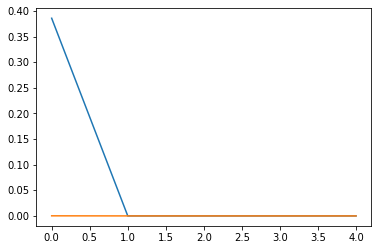

2532/2532 [==============================] - 10s 4ms/step - loss: 1.0767e-08 - accuracy: 1.0000
loss= 1.0767100100395055e-08
acc= 1.0


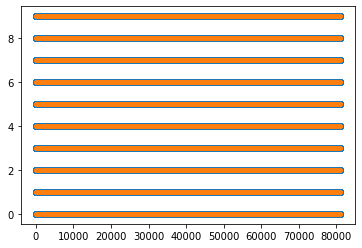

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(Bidirectional(LSTM(128), input_shape=input_shape))
model.add(RepeatVector(1))
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=5, verbose=1, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)
test_y_index = np.argmax(test_y, axis=-1)

plt.plot(test_y_index, "o")
plt.plot(predicted, ".")
plt.show()